# 今回の取り組み

- correct_sequence_errorのアルゴリズムを変更したので、Tyr, stx2, floxの結果を観察します

## いつものセットアップ

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [2]:
%%bash
# pipの更新
pip install -q -U pip
pip install -q -U -r requirements.txt

# 実験

In [4]:
%%bash
rm -rf DAJINResults/batch_tyr_50_10_01
rm -rf DAJINResults/.tempdir/batch_tyr_50_10_01
time DAJIN2 batch -f misc/data/design_batch_tyr_50_10_01.csv

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_50%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_10%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_01%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/batch_tyr_50_10_01 to see the report.

real	8m32.251s
user	6m34.831s
sys	1m5.976s


- 1%が消えてしまいました…

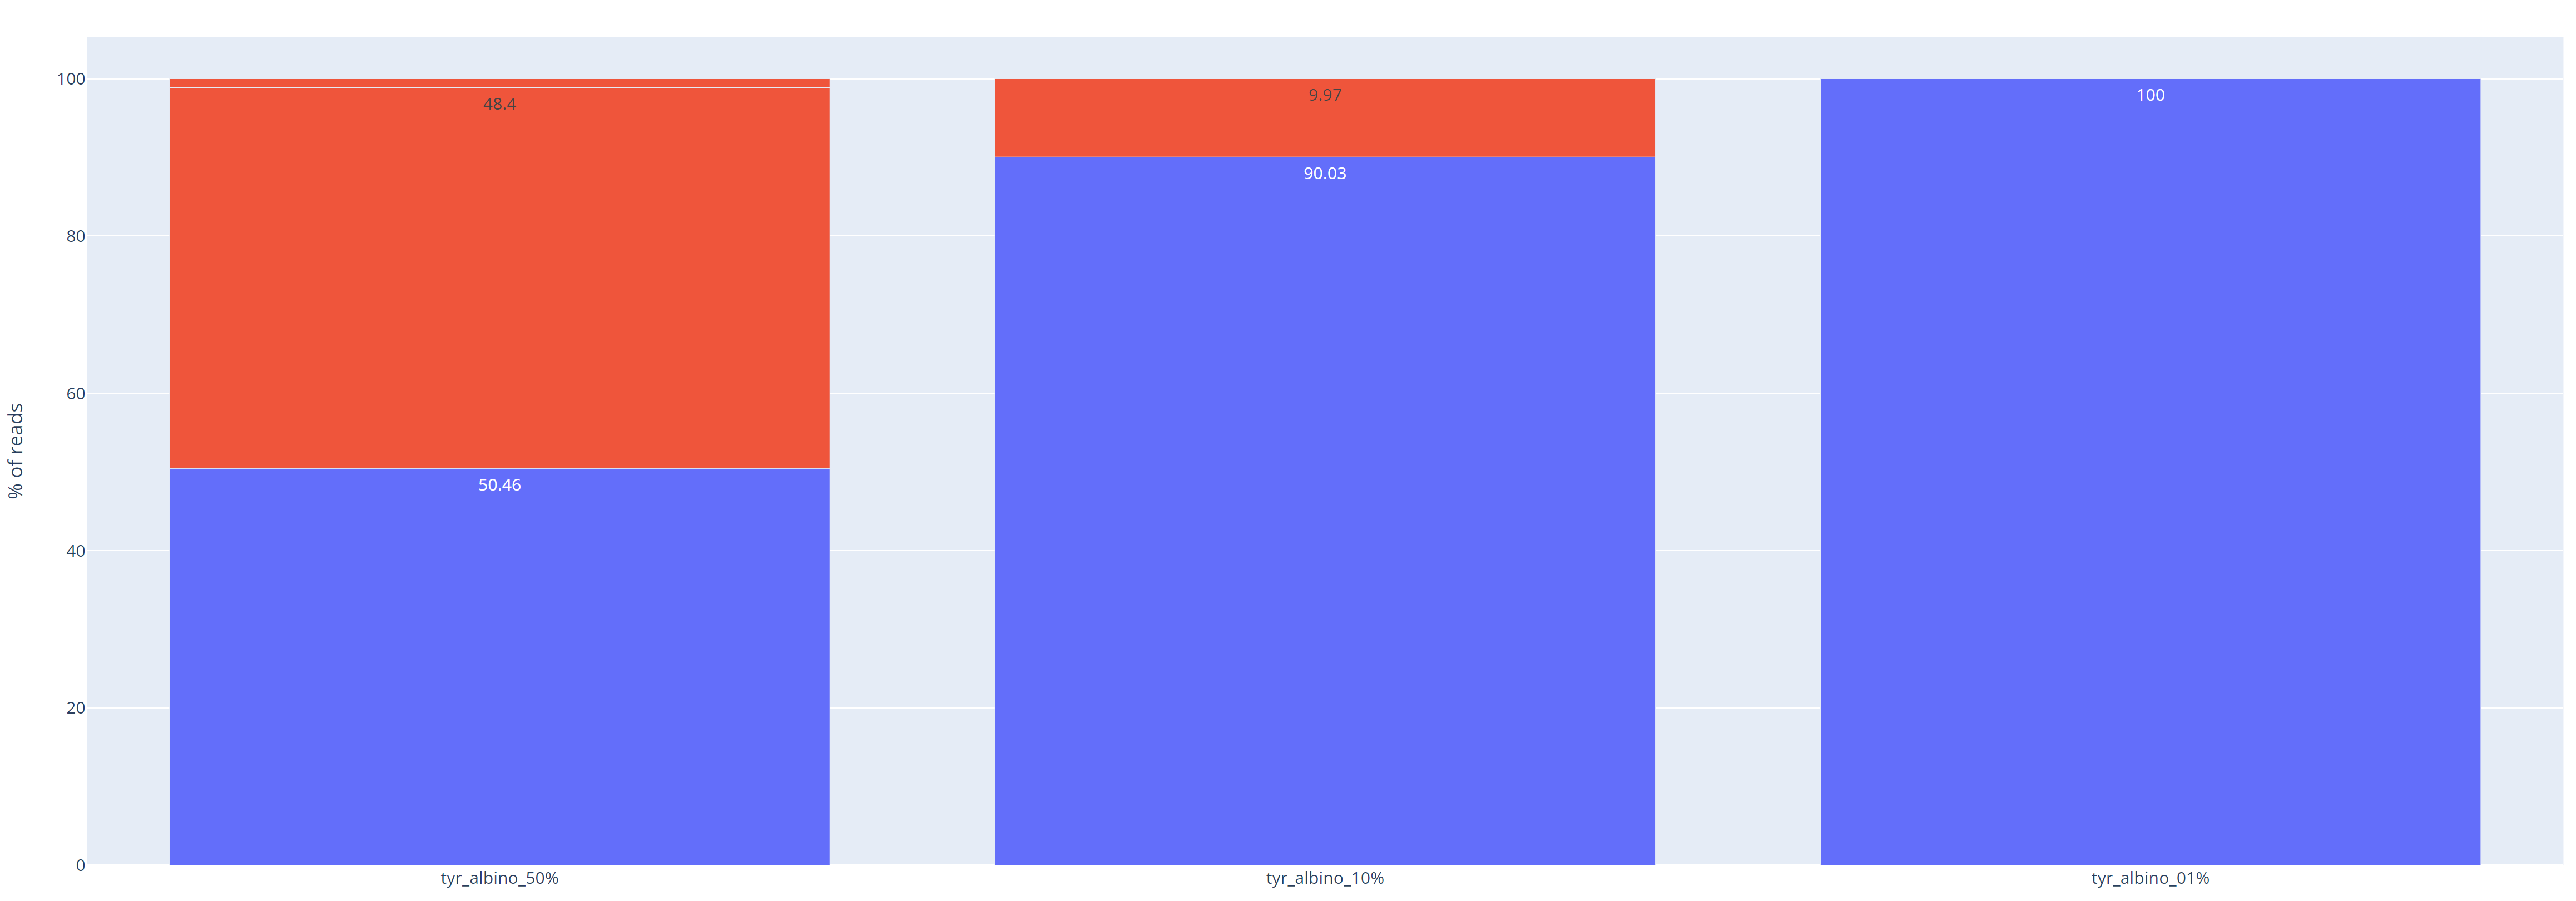

In [3]:
%%bash
rm -rf DAJINResults/single-stx2deletion
rm -rf DAJINResults/.tempdir/single-stx2deletion

time DAJIN2 \
    --name single-stx2deletion \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

tests/data/knockout/test_barcode30.fq.gz is now processing...
tests/data/knockout/test_barcode25.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-stx2deletion to see the report.

real	5m39.601s
user	5m33.224s
sys	1m13.443s


- 全然だめになってしまいましたー

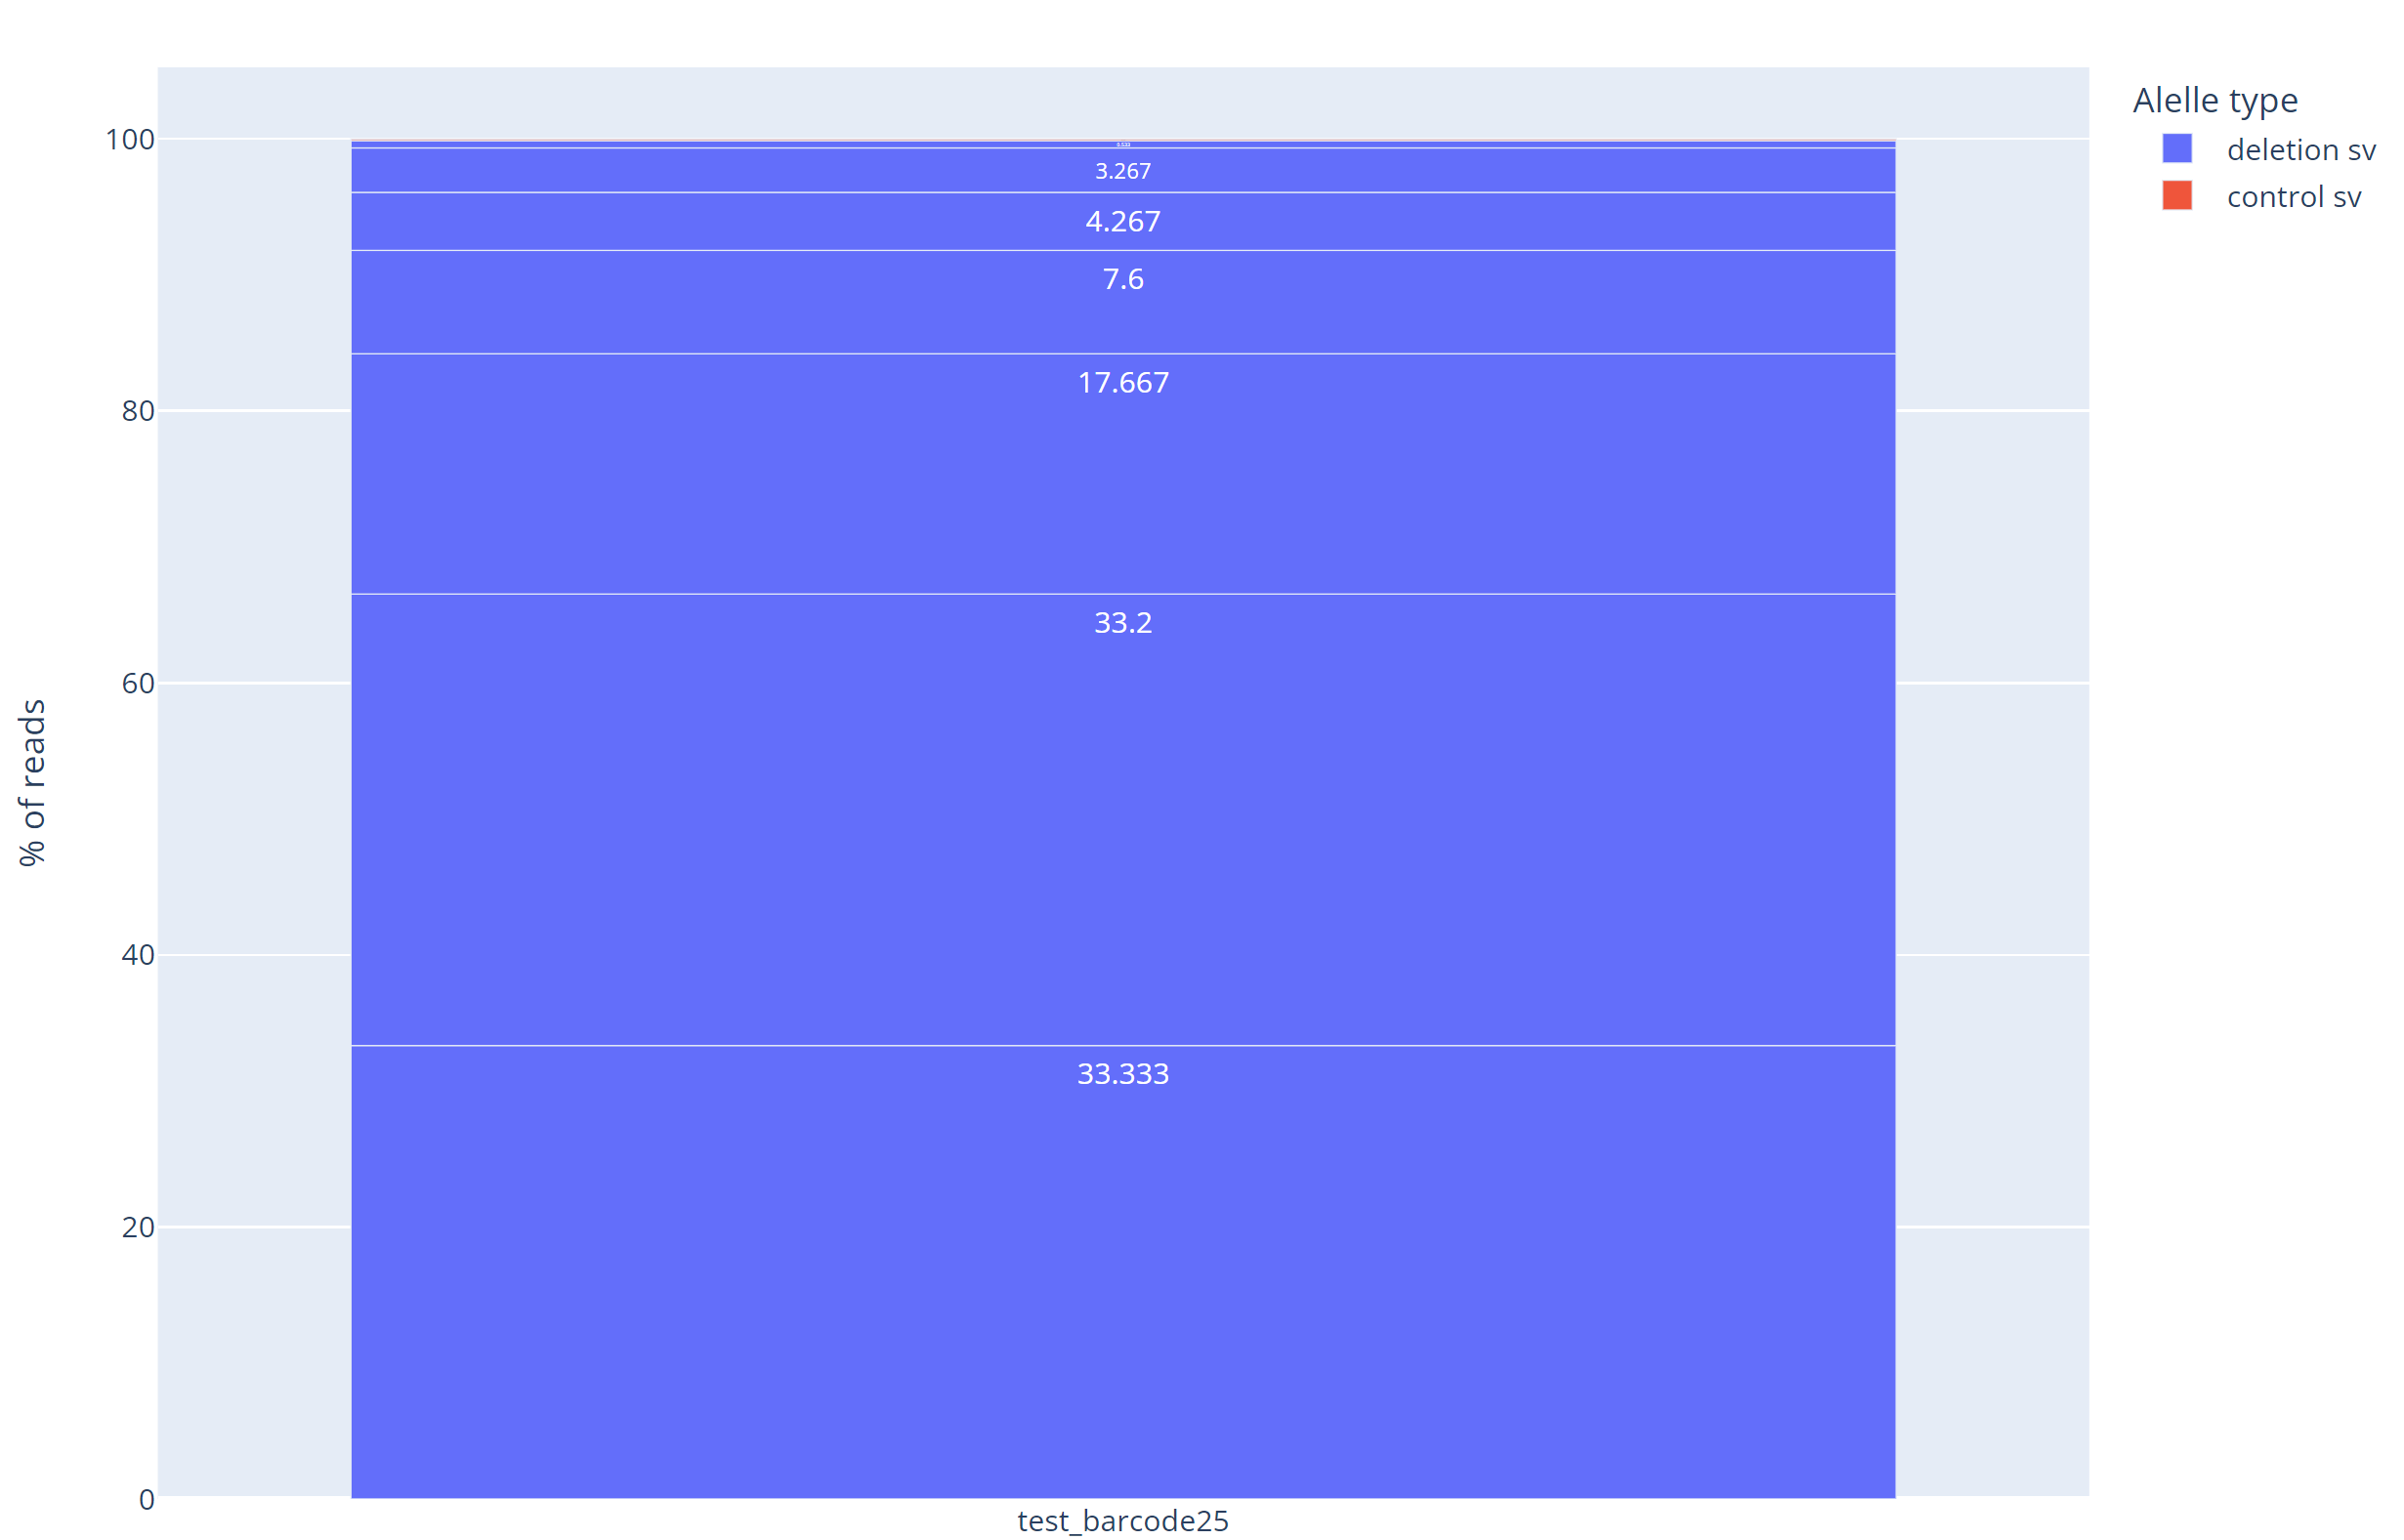

In [5]:
%%bash
rm -rf DAJINResults/single-ayabetask1
rm -rf DAJINResults/.tempdir/single-ayabetask1

time DAJIN2 \
    --name single-ayabetask1 \
    --sample examples/flox-cables2/AyabeTask1/barcode31.fq.gz \
    --control examples/flox-cables2/AyabeTask1/barcode42.fq.gz \
    --allele examples/flox-cables2/AyabeTask1/design_cables2.fa \
    --genome mm10 \
    --threads 10

examples/flox-cables2/AyabeTask1/barcode42.fq.gz is now processing...
examples/flox-cables2/AyabeTask1/barcode31.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-ayabetask1 to see the report.

real	1m5.461s
user	0m59.218s
sys	0m31.224s


- left-loxp, right-loxpはありませんが、とりあえずfloxとcontrolは分かれました

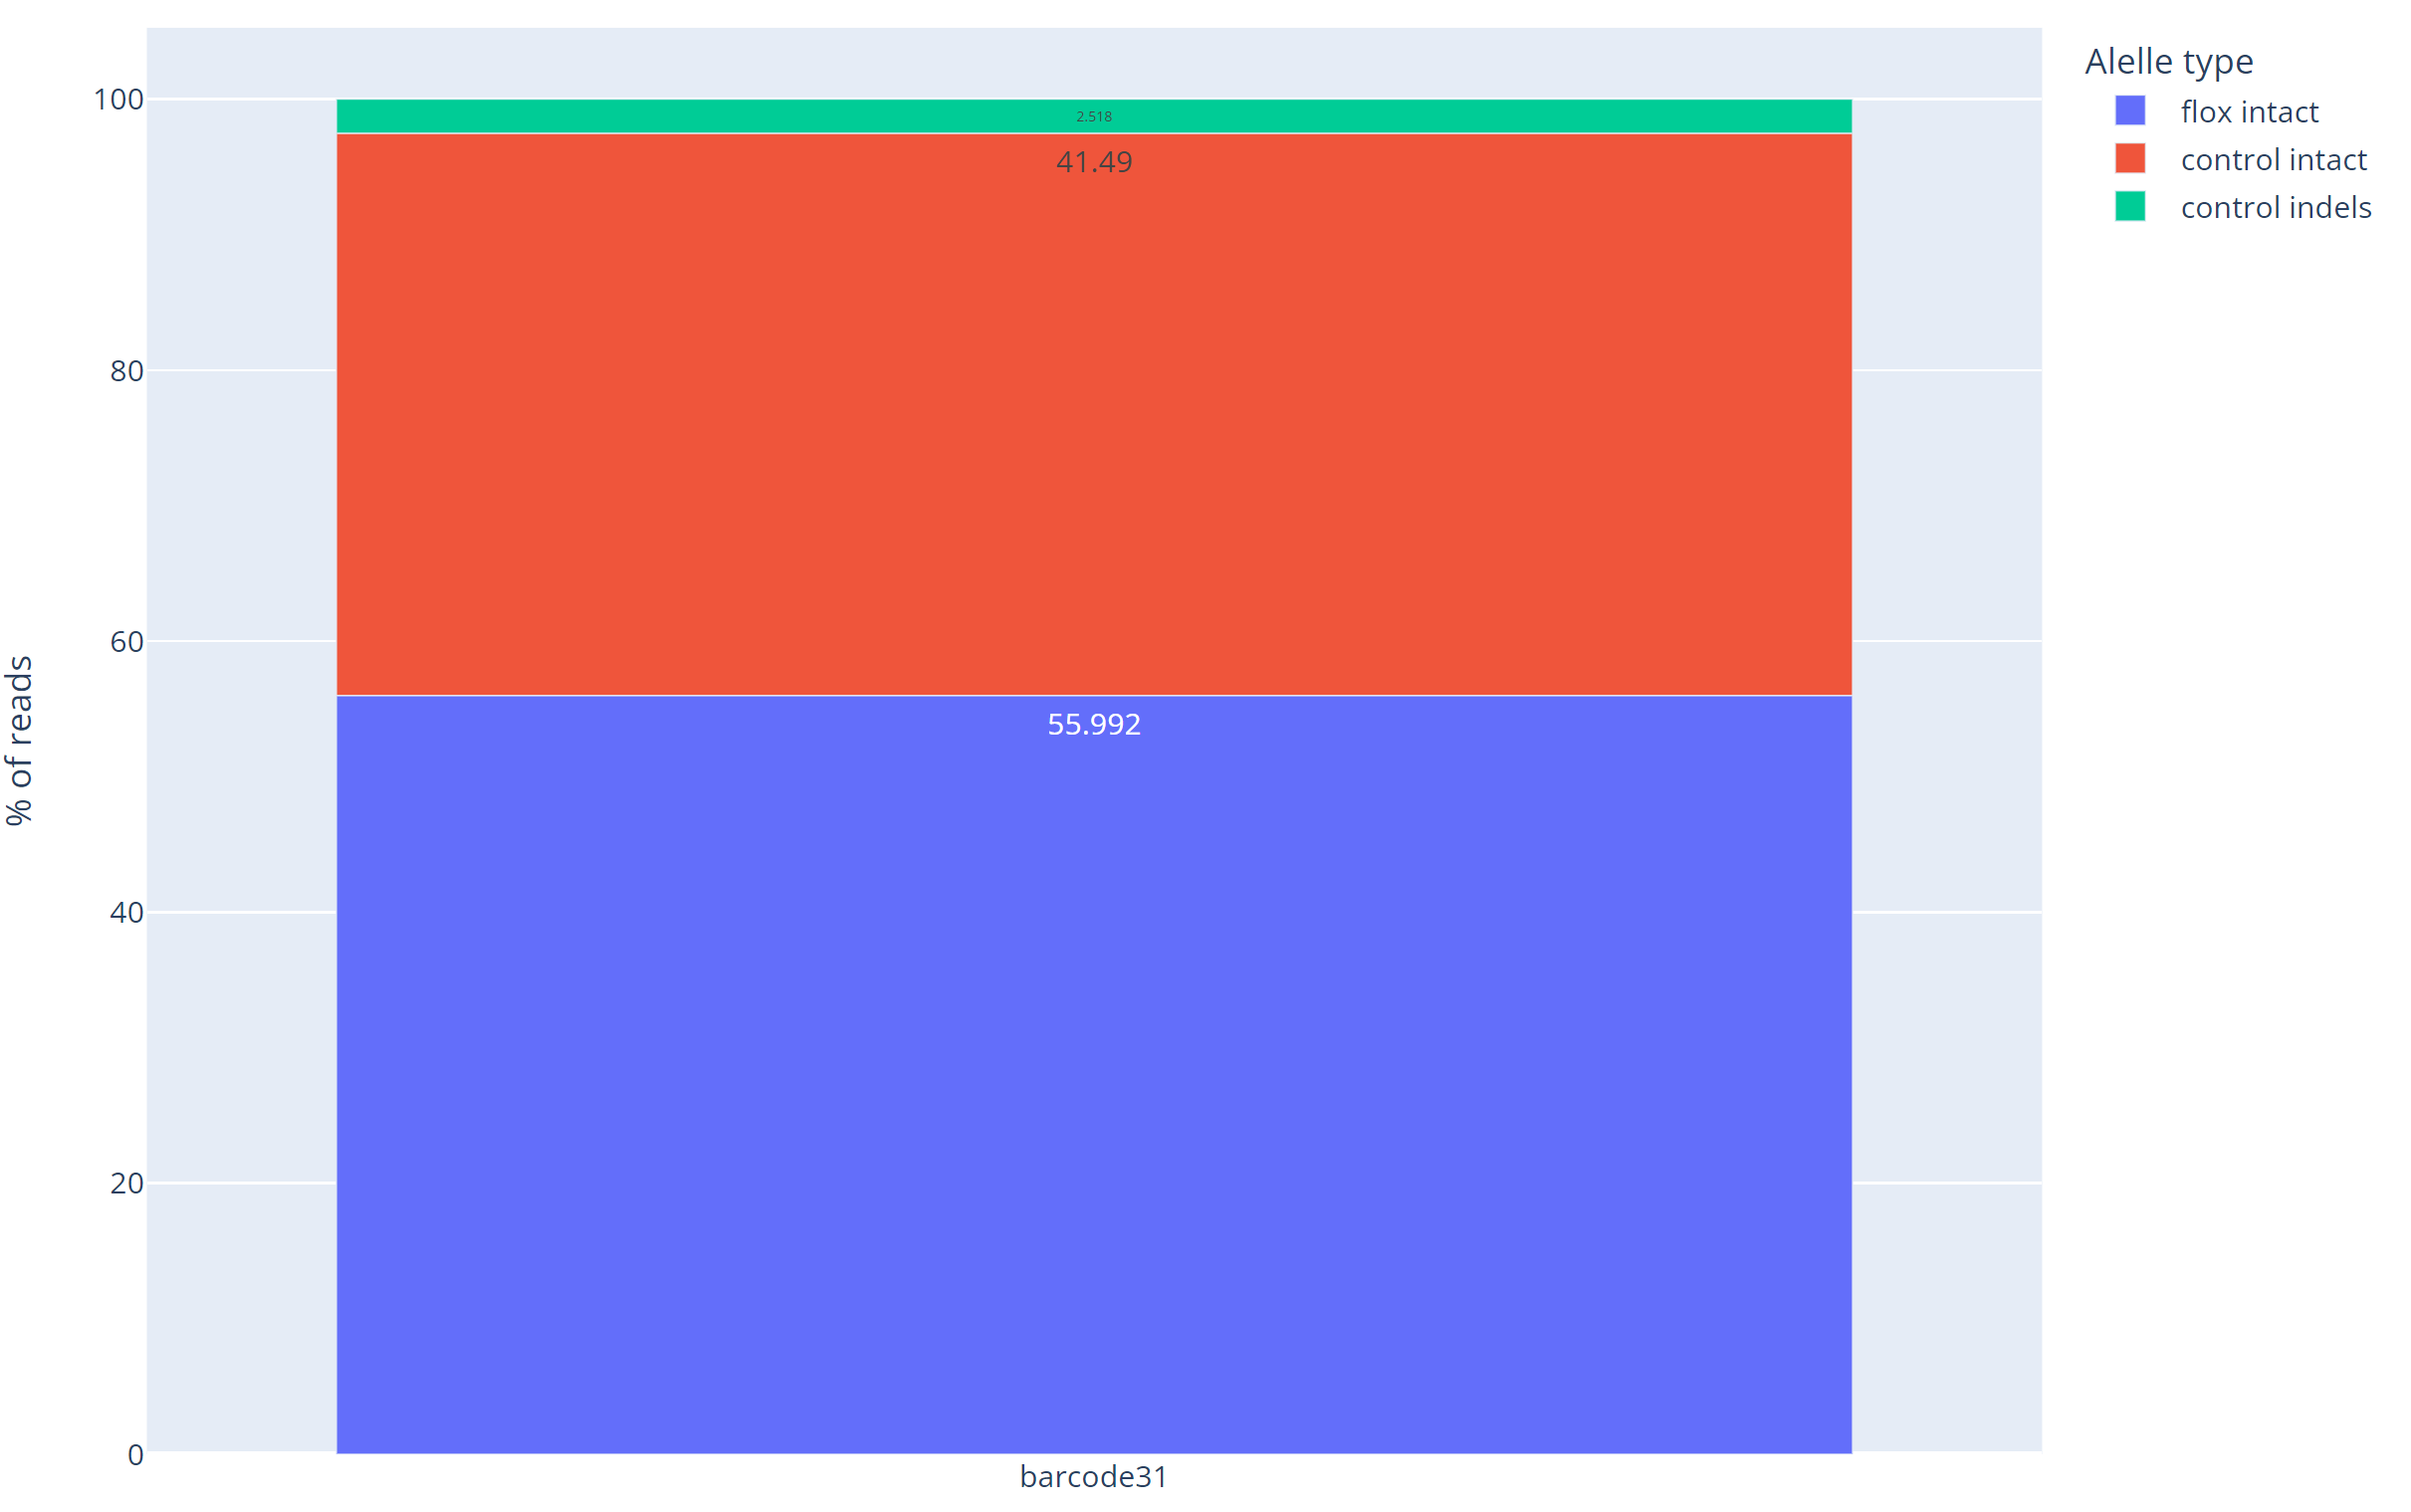

- STX2があまりにもだめになってしまったので、こちらの原因を調べます…

In [3]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path
import time

from DAJIN2.core import preprocess, classification, clustering, consensus, report


##### # * 2-cut deletion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "tests/data/knockout/test_barcode25.fq.gz",
    "tests/data/knockout/test_barcode30.fq.gz",
    "tests/data/knockout/design_stx2.fa",
    "single-stx2deletion-callmidsv",
    "mm10",
    True,
    30,
)


print(f"processing {NAME}...")

##########################################################
# Check inputs
##########################################################
print(f"validate inputs...")

print(f"check_files")
preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)

TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
print(f"IS_CACHE")
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)

UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
print(f"format inputs...")

SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = min(THREADS, os.cpu_count()-1)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

print(f"retrieve genomes...")

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)



processing test-knockout...
validate inputs...
check_files
IS_CACHE
format inputs...
retrieve genomes...


In [4]:
flag1 = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_control.jsonl").exists()
flag2 = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_control.jsonl").exists()
flag = flag1 and flag2

if not flag:
    # ====================================================================
    # Export fasta files as single-FASTA format
    # ====================================================================
    for identifier, sequence in FASTA_ALLELES.items():
        contents = "\n".join([">" + identifier, sequence]) + "\n"
        output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
        output_fasta.write_text(contents)
    # ====================================================================
    # Mapping with mappy
    # ====================================================================
    for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
        name_fasta = path_fasta.stem
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
        )
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
        )
    # ====================================================================
    # MIDSV conversion
    # ====================================================================
    for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    # ====================================================================
    # CSSPLITS Error Correction
    # ====================================================================
    preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    preprocess.correct_knockin.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    # ====================================================================
    # Convert any `N` as deletions other than consecutive `N` from both ends
    # ====================================================================
    preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, CONTROL_NAME)
    preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
    # ====================================================================
    # Cashe inputs (control)
    # ====================================================================
    if not IS_CACHE_CONTROL:
        control_hash = Path(CONTROL).read_bytes()
        control_hash = hashlib.sha256(control_hash).hexdigest()
        PATH_CACHE_HASH = Path(TEMPDIR, "cache", "control_hash.txt")
        PATH_CACHE_HASH.write_text(str(control_hash))


In [5]:
import midsv
allele = "deletion"
midsv_sample = midsv.read_jsonl(Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl"))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]

In [6]:
allele3 = "492536b4c00f"
allele4 = "f73162e8fa59"

In [10]:
# %%bash
# cat DAJINResults/.tempdir/test-ayabe-task1/sam/barcode31_splice_control.sam |
#     grep -e "^@" -e "af9e73c7f917" |
#     samtools sort > tmp_right_loxp.bam
#     samtools index tmp_right_loxp.bam

In [10]:
for i, samp in enumerate(midsv_sample):
    if allele3 in samp["QNAME"]:
        print("allele3: ", i)
    elif allele4 in samp["QNAME"]:
        print("allele4: ", i)

allele3:  67
allele4:  1056


In [12]:
idx_allele3=67
idx_allele4=1056
idx_allele = {67: "allele3", 1056: "allele4"}

In [15]:
dels = dict()
for idx, allele in idx_allele.items():
    dels_set = set()
    for i,cs in enumerate(cssplits_sample[idx]):
        if cs.startswith("-"):
            dels_set.add(i)
    dels.update({allele: dels_set})

In [21]:
print(dels["allele3"] - dels["allele4"])
print(dels["allele4"] - dels["allele3"])
print(len(dels["allele3"]))
print(len(dels["allele4"]))

sorted(list(dels["allele3"]))[-10:]

set()
{2272, 2273, 2274, 2275, 2271}
259
264


[2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270]

In [22]:
midsv_sample[idx_allele3]["CSSPLIT"]

'=G,=C,=T,=C,=C,=A,=G,=G,=G,=T,=G,=T,=C,=T,=C,=A,=T,=A,=G,=T,=G,=T,=T,=T,=G,=A,=A,=G,=G,=C,=T,=C,=C,=T,=A,=A,=A,=T,=T,=G,=C,=C,=C,=A,=G,=T,=G,=T,=T,=C,=A,=G,=C,=T,=G,=G,=G,=G,=A,=A,=A,=G,=A,=C,=C,=A,=T,=C,=A,=G,=C,=T,=A,=G,=G,=C,=A,=G,=G,=A,=T,=C,=C,=A,=A,=A,=G,=G,=A,=T,=A,=A,=T,=G,=A,=G,=T,=G,=T,=G,=C,=C,=C,=C,=A,=T,=G,=G,=G,=A,=C,=T,=C,=T,=G,=G,=C,=T,=T,=A,=G,=C,=C,=G,=C,=A,=G,=C,=T,=C,=T,=A,=C,=C,=C,=T,=A,=A,=G,=C,=C,=C,=A,=C,=A,=G,=T,=T,=G,=A,=G,=G,=G,=G,=T,=A,=G,=T,=G,=G,=A,=T,=C,=T,=T,=G,=T,=G,=T,=T,=T,=G,=A,=G,=G,=A,=C,=A,=T,=T,=A,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=G,=A,=T,=T,=G,=G,=G,=A,=A,=A,=G,=T,=A,=G,=T,=G,=G,=T,=T,=G,=C,=T,=T,=G,=A,=T,=G,=G,=A,=G,=T,=T,=G,=G,=G,=C,=T,=A,=G,=C,=G,=A,=T,=G,=G,=A,=G,=G,=T,=G,=A,=G,=T,=G,=A,=G,=T,=C,=T,=G,=G,=A,=G,=G,=C,=C,=A,=G,=T,=T,=G,=T,=G,=T,=G,=C,=C,=G,=C,=A,=T,=A,=C,=T,=A,=A,=C,=A,=G,=A,=G,=G,=A,=G,=T,=A,=A,=G,=C,=A,=C,=C,=A,=G,=C,=T,=A,=G,=A,=T,=T,=T,=T,=C,=A,=T,=T,=T,=C,=C,=T,=T,=A,=G,=G,=A,=T,=A,=T,=C,=T,=T,=T,=C,=T,=A,=A,=A,=T,=C,=T,=C,

In [23]:
midsv_sample[idx_allele4]["CSSPLIT"]

'=G,=C,=T,=C,=C,=A,=G,=G,=G,=T,=G,=T,=C,=T,=C,=A,=T,=A,=G,=T,=G,=T,=T,=T,=G,=A,=A,=G,=G,=C,=T,=C,=C,=T,=A,=A,=A,=T,=T,=G,=C,=C,=C,=A,=G,=T,=G,=T,=T,=C,=A,=G,=C,=T,=G,=G,=G,=G,=A,=A,=A,=G,=A,=C,=C,=A,=T,=C,=A,=G,=C,=T,=A,=G,=G,=C,=A,=G,=G,=A,=T,=C,=C,=A,=A,=A,=G,=G,=A,=T,=A,=A,=T,=G,=A,=G,=T,=G,=T,=G,=C,=C,=C,=C,=A,=T,=G,=G,=G,=A,=C,=T,=C,=T,=G,=G,=C,=T,=T,=A,=G,=C,=C,=G,=C,=A,=G,=C,=T,=C,=T,=A,=C,=C,=C,=T,=A,=A,=G,=C,=C,=C,=A,=C,=A,=G,=T,=T,=G,=A,=G,=G,=G,=G,=T,=A,=G,=T,=G,=G,=A,=T,=C,=T,=T,=G,=T,=G,=T,=T,=T,=G,=A,=G,=G,=A,=C,=A,=T,=T,=A,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=G,=A,=T,=T,=G,=G,=G,=A,=A,=A,=G,=T,=A,=G,=T,=G,=G,=T,=T,=G,=C,=T,=T,=G,=A,=T,=G,=G,=A,=G,=T,=T,=G,=G,=G,=C,=T,=A,=G,=C,=G,=A,=T,=G,=G,=A,=G,=G,=T,=G,=A,=G,=T,=G,=A,=G,=T,=C,=T,=G,=G,=A,=G,=G,=C,=C,=A,=G,=T,=T,=G,=T,=G,=T,=G,=C,=C,=G,=C,=A,=T,=A,=C,=T,=A,=A,=C,=A,=G,=A,=G,=G,=A,=G,=T,=A,=A,=G,=C,=A,=C,=C,=A,=G,=C,=T,=A,=G,=A,=T,=T,=T,=T,=C,=A,=T,=T,=T,=C,=C,=T,=T,=A,=G,=G,=A,=T,=A,=T,=C,=T,=T,=T,=C,=T,=A,=A,=A,=T,=C,=T,=C,

In [26]:
%%bash
# allele3 = "492536b4c00f"
# allele4 = "f73162e8fa59"

cat DAJINResults/.tempdir/single-stx2deletion/sam/test_barcode25_splice_deletion.sam |
    grep -e "^@" -e "492536b4c00f" -e "f73162e8fa59" |
    samtools sort > tmp_dels_splice.bam
    samtools index tmp_dels_splice.bam

cat DAJINResults/.tempdir/single-stx2deletion/sam/test_barcode25_map-ont_deletion.sam |
    grep -e "^@" -e "492536b4c00f" -e "f73162e8fa59" |
    samtools sort > tmp_dels_map.bam
    samtools index tmp_dels_map.bam

- 信じがたいことに、spliceとmap-ontでことなるアラインメント結果が得られました…
  - map-ontのほうが良好です
  - 一方でspliceだと大型欠失の処理が簡単であるという利点があります

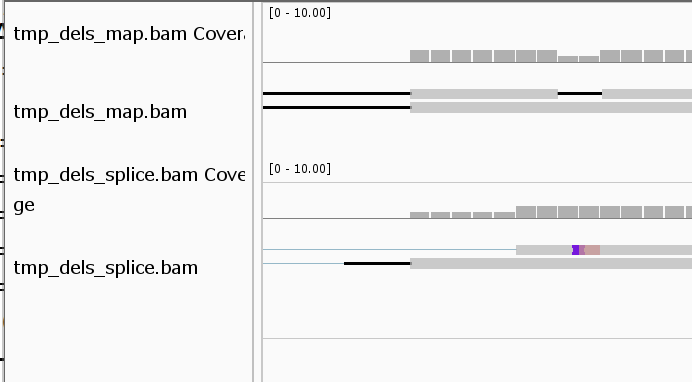

In [27]:
%%bash
cat DAJINResults/.tempdir/single-stx2deletion/sam/test_barcode25_splice_deletion.sam |
    grep -e "^@" -e "492536b4c00f" -e "edac54421680" |
    samtools sort > tmp_dels_splice_2.bam
    samtools index tmp_dels_splice_2.bam

cat DAJINResults/.tempdir/single-stx2deletion/sam/test_barcode25_map-ont_deletion.sam |
    grep -e "^@" -e "492536b4c00f" -e "edac54421680" |
    samtools sort > tmp_dels_map_2.bam
    samtools index tmp_dels_map_2.bam

ほかのリードでも確認したところ、同じく`map-ont`と`splice`で, `splice`のほうが5塩基ほど長い欠失（それを補う形で5塩基分の挿入が得られるという）アラインメント結果が得られました

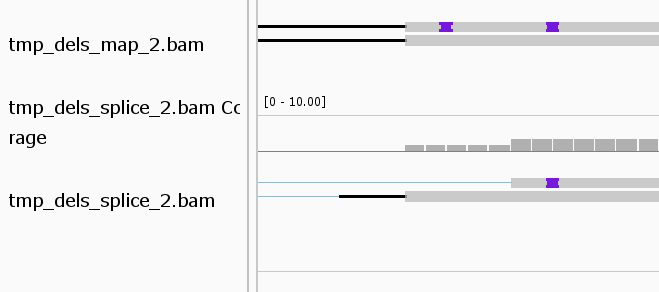

- なんでいままでこれが見逃されていたのでしょうか…？
  - Clusteringの精度的にはいまのほうが正しいわけですよね
  - 

In [28]:
%%bash
cat DAJINResults/.tempdir/single-stx2deletion/sam/test_barcode25_splice_deletion.sam |
    grep -e "^@" -e "492536b4c00f" -e "10c536940fd1" |
    samtools sort > tmp_dels_splice_allele5.bam
    samtools index tmp_dels_splice_allele5.bam

cat DAJINResults/.tempdir/single-stx2deletion/sam/test_barcode25_map-ont_deletion.sam |
    grep -e "^@" -e "492536b4c00f" -e "10c536940fd1" |
    samtools sort > tmp_dels_map_allele5.bam
    samtools index tmp_dels_map_allele5.bam

- allele5についても同様に`map-ont`と`splice`では差異が見られました
- これは`splice`だけに依存するのは危ない気がします…

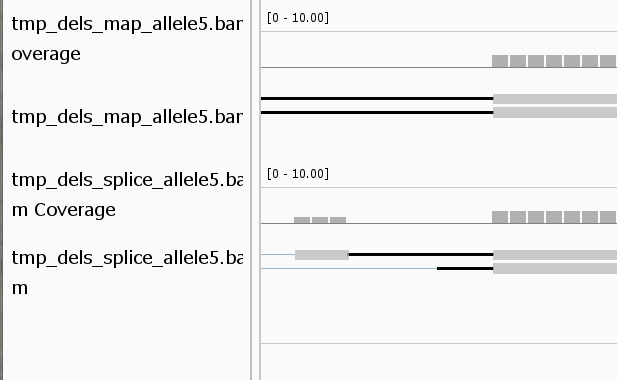

- 大型欠失のときには`splice`が有用だけれど、小規模の欠失では`map-ont`のほうが正確にマッピングされている様子です
- spliceシグナル（~gc100caみたいなやつ）があるリードだけ`splice`を利用して、それ以外は`map-ont`にする？

In [35]:
path_sam = "DAJINResults/.tempdir/single-stx2deletion/sam/test_barcode25_splice_deletion.sam"
qname_with_splice = set()
count_line = 0
with open(path_sam) as f:
    for line in f:
        count_line += 1
        line = line.split("\t")
        idx_cs = -1
        for j, col in enumerate(line):
            if col.startswith("cs"):
                idx_cs = j
        if idx_cs == -1:
            continue
        if "~" in line[idx_cs]:
            qname_with_splice.add(line[0])

print(qname_with_splice)
print(count_line)
print(len(qname_with_splice))

{'1fa1ac7d-44a0-484b-9e21-3e4d99fe2471', '1cfc1959-d3e8-4a88-bd81-e58b0edb7f7b', '1450f455-d68a-424c-aa70-d4801212824b', '058033b4-9714-49a6-8c4a-bc751614988b', '0bfa3f71-75b5-417d-88ea-efaf5764cf80', '1d86b3a6-2ac5-4b24-bd30-c9eac7dd3548', '0d9f5d5f-44aa-41c5-9d65-6b260e0fbd13', '19201c84-5910-4eb0-9c8f-774cb5d91ef8', '29463233-f02a-433a-91ed-49d760e500b0', '060761b9-c323-47df-bb91-c4b745ed1bdd', '0180b9a8-456d-424b-afb2-70b838eee4a6', '0b0d6fcc-4837-4ab1-be4f-0b62292c76ae', '0d672f1a-b2f8-438d-b8ef-e5ce71ec03db', '01e4befb-4526-4d42-8b19-5e7346a23746', '49e35af3-89f0-457e-a2e2-3c1f4bd0bd29', '0a3e9c79-d26a-4cc7-a752-585301919d0b', '01f29f6c-bdc3-4412-a3ac-13da8981d57d', '05e8c02f-4fcb-4fc0-848d-071e25c4f05b', '3f64c4ce-835f-4e50-8fc6-ae851e4b4bc6', '10711a9a-a984-4c1c-b169-d8d7c226441d', '253aca25-35f6-4aa3-8e88-a4bb65e7fc6c', '10b2635f-d487-453b-bc39-3f7aff2243b8', '1255f0b5-5408-48ed-ad36-04265c3ab1bf', '066949db-3ff7-48bc-a074-289db83c1d60', '1c5c4a4c-0973-4a93-9564-6166781f8989',

- 逆のほうが良さそう
    - `map-ont`で単一のリードとしてカウントされているものは`map-ont`, 複数のリードにバラけているものは`splice`を使用する

In [91]:

def get_qname_of_single_read(path_sam: str | Path) -> set():
    count_qname = defaultdict(int)
    with open(path_sam) as f:
        for line in f:
            qname = line.split("\t")[0]
            count_qname[qname] += 1
    qname_of_single_read = set()
    for key, count in count_qname.items():
        if count == 1:
            qname_of_single_read.add(key)
    return qname_of_single_read

def extract_sam(path_sam: str | Path, qname_of_single_read: set, single:bool=True) -> list:
    sam = midsv.read_sam(path_sam)
    sam_extracted = []
    for s in sam:
        if s[0].startswith("@"):
            sam_extracted.append(s)
        if single:
            if s[0] in qname_of_single_read:
                sam_extracted.append(s)
        else:
            if s[0] not in qname_of_single_read:
                sam_extracted.append(s)
    return sam_extracted

def midsv_transform(sam: list[list[str]]) -> list[list[str]]:
    num_header = 0
    for s in sam:
        if s[0].startswith("@"):
            num_header += 1
        else:
            break
    if len(sam) == num_header:
        return []
    return midsv.transform(sam, midsv=False, cssplit=True, qscore=False)

In [70]:

allele="deletion"
def call_midsv(TEMPDIR, SAMPLE_NAME, allele) -> None:
    path_sam_ont = f"{TEMPDIR}/sam/{SAMPLE_NAME}_map-ont_{allele}.sam"
    path_sam_splice = f"{TEMPDIR}/sam/{SAMPLE_NAME}_splice_{allele}.sam"
    qname_of_single_read = get_qname_of_single_read(path_sam_ont)
    sam_of_single_read = extract_sam(path_sam_ont, qname_of_single_read)
    sam_of_multiple_reads = extract_sam(path_sam_splice, qname_of_single_read, single=False)
    midsv_of_single_read = midsv_transform(sam_of_single_read)
    midsv_of_multiple_reads = midsv_transform(sam_of_multiple_reads)
    midsv_sample = midsv_of_single_read + midsv_of_multiple_reads
    midsv.write_jsonl(midsv_sample, f"{TEMPDIR}/midsv/{SAMPLE_NAME}_{allele}.jsonl")

In [92]:
print(len(midsv_of_single_read))
print(len(midsv_of_multiple_reads))

1305
195


- `call_midsv`で`map_ont`と`splice`の結果を結合しました
    - `map_ont`にてユニークなリードは`map_ont`、複数にアライメントされたリードは`splice`のCSTAGをもとにmidsv変換をする形にしました
    - `map_ont`にも`splice`にもミスアラインメントがあるので、両者の強みをいかしたリード情報を抽出する目論見です
    - これで最良？のアラインメント結果が得られると良いのですが…

In [104]:
%%bash
rm -rf DAJINResults/single-stx2deletion-callmidsv
rm -rf DAJINResults/.tempdir/single-stx2deletion-callmidsv

time DAJIN2 \
    --name single-stx2deletion-callmidsv \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

tests/data/knockout/test_barcode30.fq.gz is now processing...
tests/data/knockout/test_barcode25.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-stx2deletion-callmidsv to see the report.

real	5m39.623s
user	7m20.020s
sys	4m36.216s


- `clustering`で謎なエラーが出ました…

In [102]:
NAME = "single-stx2deletion-callmidsv"
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)

In [97]:
from __future__ import annotations

from collections import defaultdict
from itertools import groupby
from pathlib import Path

import midsv

from DAJIN2.core.clustering.make_score import make_score
from DAJIN2.core.clustering.return_labels import return_labels
from DAJIN2.core.preprocess.correct_knockin import extract_knockin_loci


def _compress_insertion(cssplits: list[list[str]]) -> list[dict[str, int]]:
    """Insertion will be subdivided by sequence error in the its sequence, so it is compressed as a '+I' to eliminate mutations.
    #TODO ただ、これでは、insertion配列の中に真のmutationがある場合に、そのmutationを抽出できないので、**insertion配列の中にmutationがある場合は、insertion配列をそのまま残す**必要がある。
    """
    cssplits_abstracted = []
    for cssplit in cssplits:
        for i, cs in enumerate(cssplit):
            if cs.startswith("+"):
                cssplit[i] = "+I" + cs.split("|")[-1]
        cssplits_abstracted.append(cssplit)
    return cssplits_abstracted


def _extract_cssplits_in_mutation_by_3mer(cssplits_sample: list[list], mutation_loci: set) -> list[list]:
    cssplits_mutation = []
    for cssplits in cssplits_sample:
        cs_mutation = []
        for i in range(1, len(cssplits) - 1):
            if i in mutation_loci:
                kmer = ",".join([cssplits[i - 1], cssplits[i], cssplits[i + 1]])
                cs_mutation.append(kmer)
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation


def _annotate_score(cssplits: list[list[str]], mutation_score: list[dict[str:float]]) -> list[list[float]]:
    scores = []
    for cssplit in cssplits:
        score = []
        for cs, mutscore in zip(cssplit, mutation_score):
            if mutscore == {}:
                score.append(0)
                continue
            mutation = list(mutscore.keys())[0]
            value = list(mutscore.values())[0]
            if cs == mutation:
                score.append(value)
            else:
                score.append(0)
        scores.append(score)
    return scores


def _reorder_labels(labels: list[int], start: int = 0) -> list[int]:
    labels_ordered = labels.copy()
    num = start
    d = defaultdict(int)
    for i, l in enumerate(labels_ordered):
        if not d[l]:
            num += 1
            d[l] = num
        labels_ordered[i] = d[l]
    return labels_ordered


def add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS: int = 1) -> list[dict[str]]:
    knockin_alleles = extract_knockin_loci(TEMPDIR)
    labels_all = []
    max_label = 0
    classif_sample.sort(key=lambda x: x["ALLELE"])
    for allele, group in groupby(classif_sample, key=lambda x: x["ALLELE"]):
        mutation_loci: dict[int, str] = MUTATION_LOCI[allele]
        if mutation_loci == {}:
            labels_all.extend([1] * len(classif_sample))
            continue
        knockin_loci: set = knockin_alleles[allele]
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in group]
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        cssplits_control = _compress_insertion(cssplits_control)
        cssplits_sample = _compress_insertion(cssplits_sample)
        cssplits_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
        cssplits_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
        mutation_score = make_score(cssplits_control, cssplits_sample)
        scores_control = _annotate_score(cssplits_control, mutation_score)
        scores_sample = _annotate_score(cssplits_sample, mutation_score)
        labels = return_labels(scores_sample, scores_control)
        labels_reorder = _reorder_labels(labels, start=max_label)
        max_label = max(labels_reorder)
        labels_all.extend(labels_reorder)
    clust_sample = classif_sample.copy()
    for clust, label in zip(clust_sample, labels_all):
        clust["LABEL"] = label
    return clust_sample


def add_readnum(clust_sample: list[dict]) -> list[dict]:
    clust_result = clust_sample.copy()
    readnum = defaultdict(int)
    for cs in clust_result:
        readnum[cs["LABEL"]] += 1
    for cs in clust_result:
        cs["READNUM"] = readnum[cs["LABEL"]]
    return clust_result


def add_percent(clust_sample: list[dict]) -> list[dict]:
    clust_result = clust_sample.copy()
    n_sample = len(clust_result)
    percent = defaultdict(int)
    for cs in clust_result:
        percent[cs["LABEL"]] += 1 / n_sample
    percent = {key: round(val * 100, 3) for key, val in percent.items()}
    for cs in clust_result:
        cs["PERCENT"] = percent[cs["LABEL"]]
    return clust_result


def update_labels(clust_sample: list[dict]) -> list[dict]:
    """
    Allocate new labels according to the ranking by PERCENT
    """
    clust_result = clust_sample.copy()
    clust_result.sort(key=lambda x: (-x["PERCENT"], x["LABEL"]))
    new_label = 1
    prev_label = clust_result[0]["LABEL"]
    for cs in clust_result:
        if prev_label != cs["LABEL"]:
            new_label += 1
        prev_label = cs["LABEL"]
        cs["LABEL"] = new_label
    return clust_result


In [103]:
classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)
MUTATION_LOCI = clustering.extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)

FileNotFoundError: [Errno 2] No such file or directory: 'DAJINResults/.tempdir/single-stx2deletion-callmidsv/midsv/test_barcode25_splice_deletion.jsonl'

In [101]:
paths_midsv = list(Path(TEMPDIR, "midsv").glob(f"{SAMPLE_NAME}*.jsonl"))
print(paths_midsv)

[PosixPath('DAJINResults/.tempdir/test-knockout/midsv/test_barcode25_splice_deletion.jsonl'), PosixPath('DAJINResults/.tempdir/test-knockout/midsv/test_barcode25_splice_control.jsonl'), PosixPath('DAJINResults/.tempdir/test-knockout/midsv/test_barcode25_splice_inversion.jsonl')]


In [ ]:
allele = "deletion"
knockin_alleles = extract_knockin_loci(TEMPDIR)
labels_all = []
max_label = 0

mutation_loci: dict[int, str] = MUTATION_LOCI[allele]
if mutation_loci == {}:
    labels_all.extend([1] * len(classif_sample))
    continue
knockin_loci: set = knockin_alleles[allele]
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in group]
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
cssplits_control = _compress_insertion(cssplits_control)
cssplits_sample = _compress_insertion(cssplits_sample)
cssplits_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
cssplits_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
mutation_score = make_score(cssplits_control, cssplits_sample)
scores_control = _annotate_score(cssplits_control, mutation_score)
scores_sample = _annotate_score(cssplits_sample, mutation_score)
labels = return_labels(scores_sample, scores_control)


In [49]:
%%bash
rm -rf DAJINResults/single-stx2deletion-callmidsv
rm -rf DAJINResults/.tempdir/single-stx2deletion-callmidsv

time DAJIN2 \
    --name single-stx2deletion-callmidsv \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

tests/data/knockout/test_barcode30.fq.gz is now processing...
tests/data/knockout/test_barcode25.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-stx2deletion-callmidsv to see the report.

real	5m46.992s
user	7m13.185s
sys	4m15.255s


- ひっちゃかめっちゃかな結果になりました…

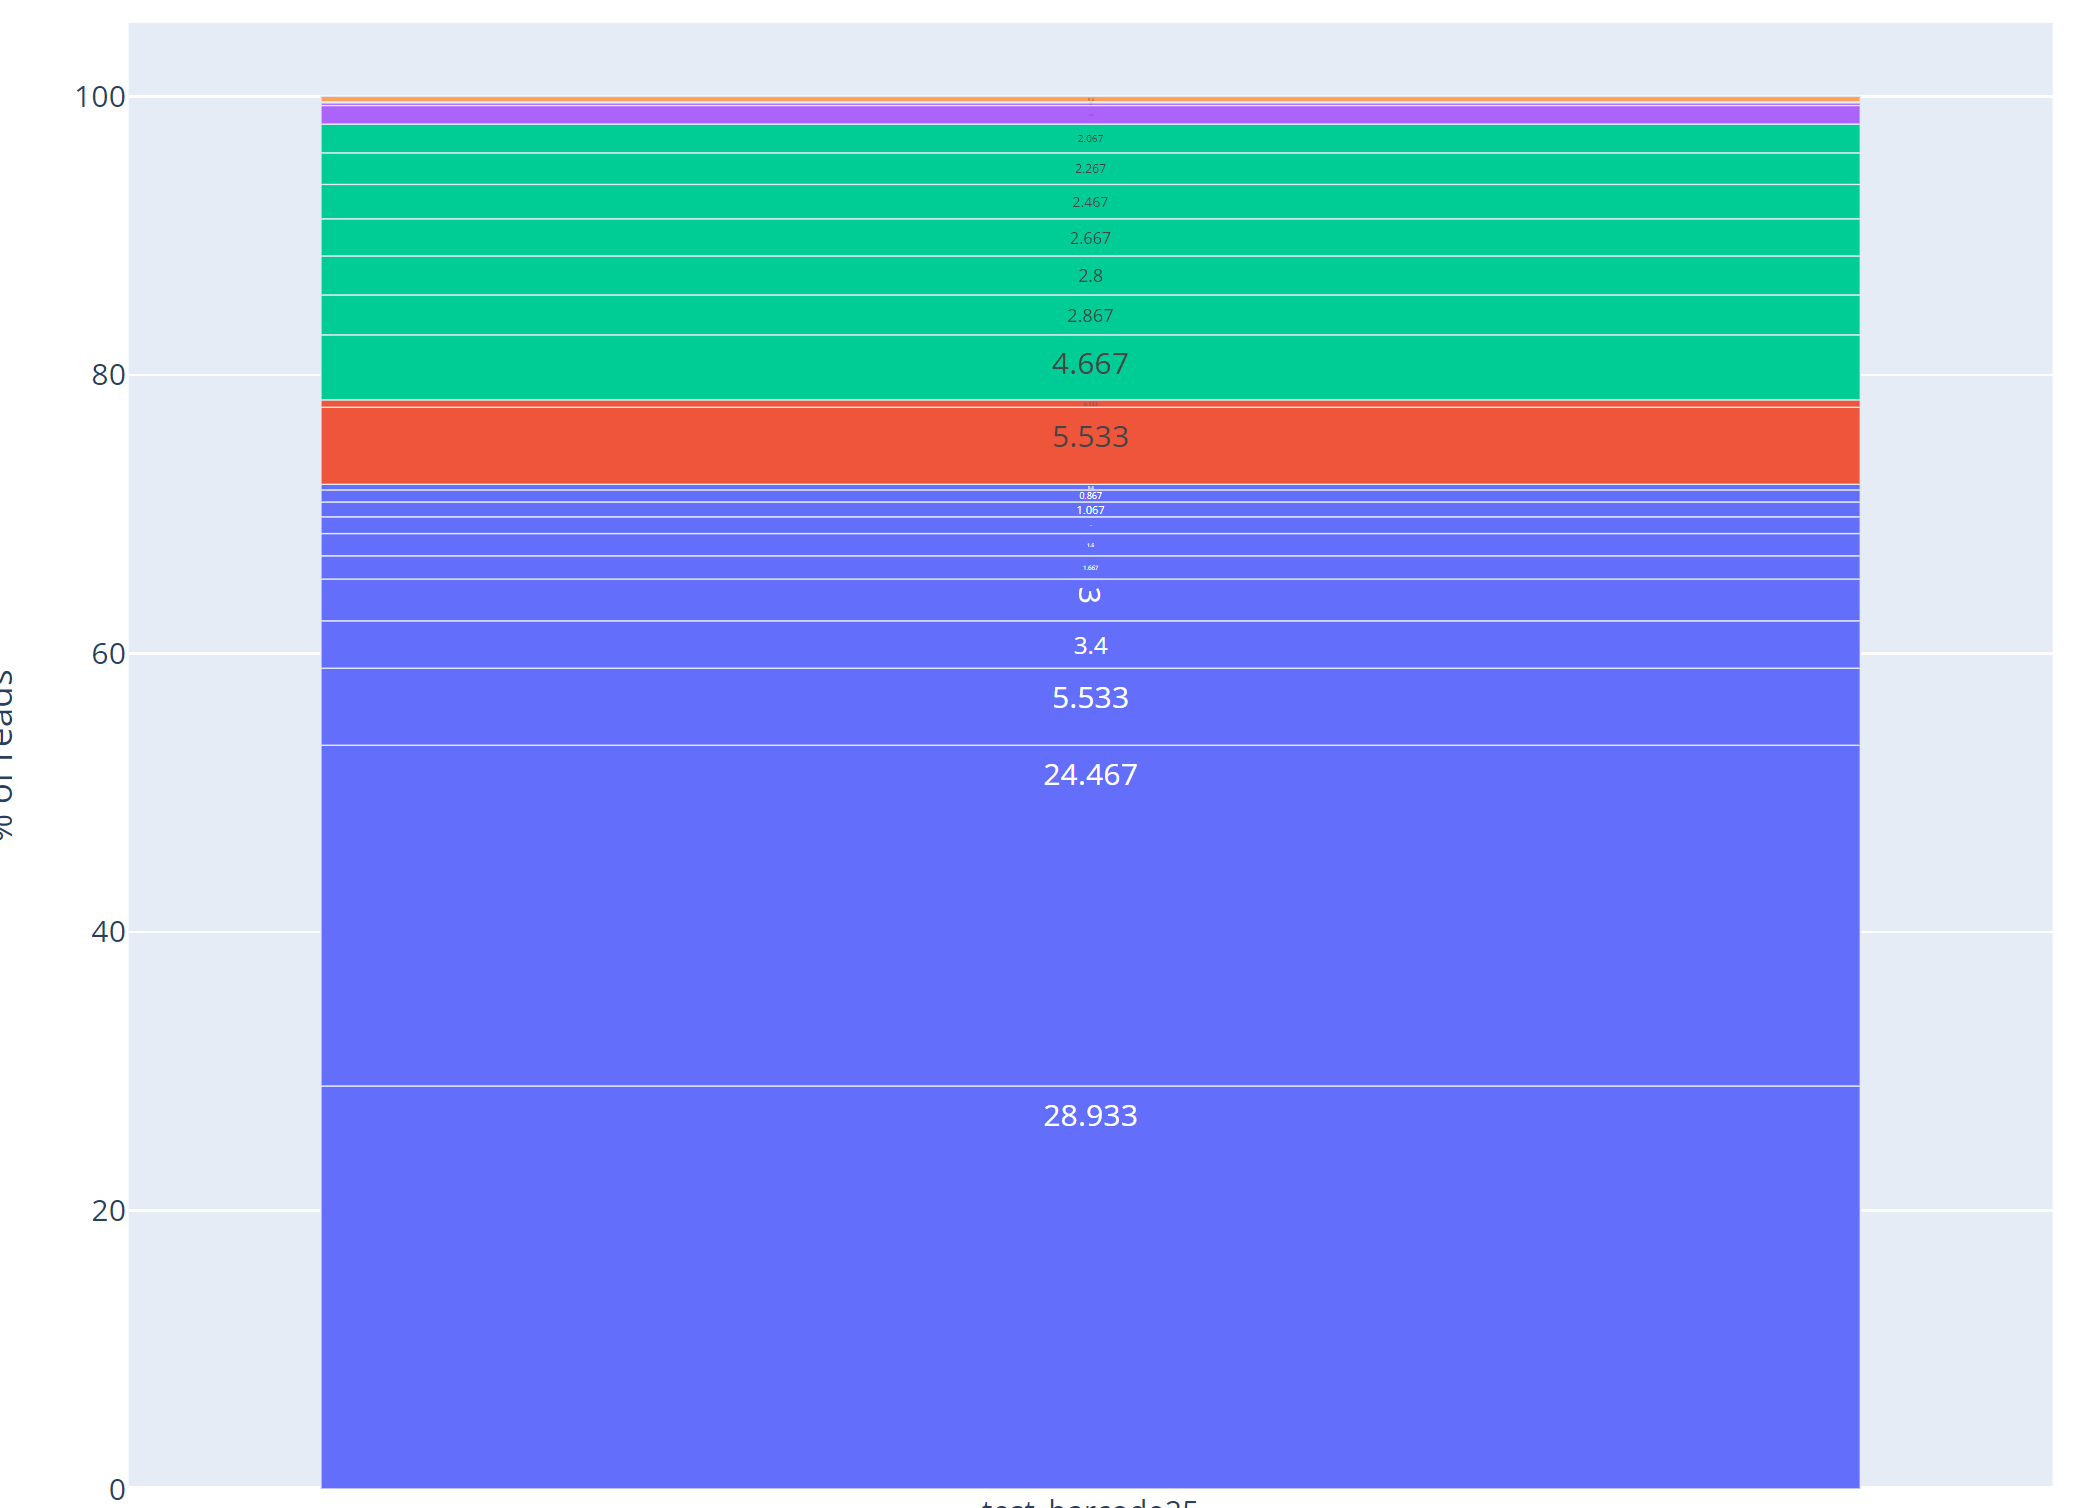

- とりあえずcontrolに分類されるリードがあるのはおかしすぎるので、次回はこの原因を調べます
- `map_ont`と`splice`のいいとこ取りをするアイディアは良いと思うので、しばらくこの考えは保持していきたいと思います。
- だめなら0417時点くらいにまで戻ります。

# 👉👉👉 いまここ 👈👈👈

# 👌👌👌 まとめ 👌👌👌


- 長くなってきたので一旦ここでまとめます

- `correct_sequence_error`を改善？したのちにTyrやStx2で試したのですが、いまいちでした
- 調べてみると、`map-ont`と`splice`でアラインメント結果が異なることが原因でした
    - いまの`correct_sequence_error`ではアラインメント情報を以前よりも正しく捉えられているようでした
    - なのでアルゴリズムは継続しようと思っています
- `map-ont`と`splice`の違いを考慮するために、それぞれの強みを生かして超大型欠失がない場合（単一のアラインメント）のときには`map-ont`、それ以外には`splice`を使うという形にしました
    - そうするとなぜかStx2の分類結果がめちゃくちゃになりました
    - とくに`control`が出てくるのが謎すぎるので、次回検討します

# 次に取り組むこと

- 現状のアルゴリズムの動作確認をTyr, Stx2, Floxで行う
- mutation_lociをpreprocessで使用したものに変更する

### Lists

+ ⬜ Insertionのなかにある変異を同定する手法を考案する
+ ⬜ Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ ✅ 断端リードの扱いをどうするべきか
+ ✅ `SV`の判定をconsensus callのあとにする
> + ⬜ `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする